<a href="https://colab.research.google.com/github/palakagl/NLP/blob/main/Wysdom_PersonalAssistant_Hybrid_XGBoost_NB_RF_CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 4.0 MB 45.4 MB/s 
     |████████████████████████████████| 1.2 MB 55.1 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 36.7 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=7c66dcda76cda6d417b8cc4129055ecf4e33751032ccd6ef002566f5bb7b60f0
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 48 kB/s 


In [22]:
import datetime
import pandas as pd
import numpy as np
import os
import re

import nltk
import io
from nltk import word_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sentence_transformers import SentenceTransformer, LoggingHandler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving personal_assistant_train.csv to personal_assistant_train.csv


In [5]:
df = pd.read_csv(io.BytesIO(uploaded['personal_assistant_train.csv']))
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8884 entries, 0 to 8883
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       8884 non-null   int64 
 1   message  8884 non-null   object
 2   label    8884 non-null   object
dtypes: int64(1), object(2)
memory usage: 208.3+ KB
None
      id                                            message             label
0  10480                           start the robotic vacuum      iot_cleaning
1   4210          i am sorry but i think you are not right.    general_negate
2   2443  what is the time difference between california...  datetime_convert
3   5869                              tell me my list names       lists_query
4   2801                 beep when i get an email from john       email_query


In [6]:
df.head()

,id,message,label
0,10480,start the robotic vacuum,iot_cleaning
1,4210,i am sorry but i think you are not right.,general_negate
2,2443,what is the time difference between california...,datetime_convert
3,5869,tell me my list names,lists_query
4,2801,beep when i get an email from john,email_query


encoding labels

In [7]:
# Encode the labels
df['encoded_label'] = df['label'].astype('category').cat.codes
b = df['label'].astype('category')

#Create the category mapping to map it back
cat_map = dict(enumerate(b.cat.categories))
df.head()

,id,message,label,encoded_label
0,10480,start the robotic vacuum,iot_cleaning,26
1,4210,i am sorry but i think you are not right.,general_negate,22
2,2443,what is the time difference between california...,datetime_convert,10
3,5869,tell me my list names,lists_query,36
4,2801,beep when i get an email from john,email_query,13


In [9]:
cat_map

{0: 'alarm_query',
 1: 'alarm_remove',
 2: 'alarm_set',
 3: 'audio_volume_down',
 4: 'audio_volume_mute',
 5: 'audio_volume_up',
 6: 'calendar_query',
 7: 'calendar_remove',
 8: 'calendar_set',
 9: 'cooking_recipe',
 10: 'datetime_convert',
 11: 'datetime_query',
 12: 'email_addcontact',
 13: 'email_query',
 14: 'email_querycontact',
 15: 'email_sendemail',
 16: 'general_affirm',
 17: 'general_commandstop',
 18: 'general_confirm',
 19: 'general_dontcare',
 20: 'general_explain',
 21: 'general_joke',
 22: 'general_negate',
 23: 'general_praise',
 24: 'general_quirky',
 25: 'general_repeat',
 26: 'iot_cleaning',
 27: 'iot_coffee',
 28: 'iot_hue_lightchange',
 29: 'iot_hue_lightdim',
 30: 'iot_hue_lightoff',
 31: 'iot_hue_lighton',
 32: 'iot_hue_lightup',
 33: 'iot_wemo_off',
 34: 'iot_wemo_on',
 35: 'lists_createoradd',
 36: 'lists_query',
 37: 'lists_remove',
 38: 'music_likeness',
 39: 'music_query',
 40: 'music_settings',
 41: 'news_query',
 42: 'play_audiobook',
 43: 'play_game',
 44

In [8]:
x=df['message']
y=df['encoded_label']

In [9]:
x.head()

0                             start the robotic vacuum
1            i am sorry but i think you are not right.
2    what is the time difference between california...
3                                tell me my list names
4                   beep when i get an email from john
Name: message, dtype: object

In [10]:
y.head()

0    26
1    22
2    10
3    36
4    13
Name: encoded_label, dtype: int8

In [11]:
from google.colab import files
uploaded = files.upload()

Saving personal_assistant_test.csv to personal_assistant_test.csv


In [12]:
df_test = pd.read_csv(io.BytesIO(uploaded['personal_assistant_test.csv']))
print(df_test.info())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2221 non-null   int64 
 1   message  2221 non-null   object
dtypes: int64(1), object(1)
memory usage: 34.8+ KB
None
      id                                     message
0  10873  list the current price of microsoft shares
1   8491             where is the nearest smoke shop
2   4549                          please start over.
3   5948                         read my lists to me
4   1663                             mute volume now


In [13]:
X_test=df_test['message']

# Embeddings 

In [14]:
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

x_embeddings = embedder.encode(x, convert_to_numpy=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [15]:
x_embeddings

array([[-0.58878154, -0.15007067, -0.24277799, ...,  0.32644966,
        -0.46130717, -0.31849858],
       [ 0.21024762, -0.15945102,  0.343908  , ...,  0.08609005,
         0.7630389 , -0.13470551],
       [ 1.0719684 , -0.67465806,  0.5029025 , ..., -0.0376763 ,
        -0.700196  ,  0.12923099],
       ...,
       [-0.15600443,  0.10299416,  0.41830662, ...,  0.66244394,
        -0.36820138,  0.23117268],
       [ 0.00289339, -0.31685743,  0.5755867 , ...,  0.35636115,
        -0.00232111,  0.4772692 ],
       [-0.6391247 , -0.29570377,  0.00930487, ...,  0.53227025,
        -0.20714241,  0.23913126]], dtype=float32)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(x_embeddings, y, test_size=0.2, random_state=42)



# Build Model XGBOOST

In [18]:
model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
#model = XGBClassifier(colsample_bytree= 1.0, eta= 0.01, eval_metric = 'mae', max_depth = 10, min_child_weight = 6, objective = 'reg:linear', 'subsample': 0.8)

model.fit(X_train, Y_train)

XGBClassifier(max_depth=5, objective='multi:softprob')

In [19]:
pred_val =model.predict(X_val)

In [20]:
print(confusion_matrix(Y_val, pred_val))
print(classification_report(Y_val, pred_val))

[[25  0  4 ...  0  0  0]
 [ 1 19  2 ...  0  0  0]
 [ 2  1 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 29]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.95      0.83      0.88        23
           2       0.71      0.76      0.73        29
           3       0.83      0.83      0.83        12
           4       0.80      0.87      0.83        23
           5       1.00      0.75      0.86        24
           6       0.69      0.77      0.73        31
           7       0.97      0.90      0.93        31
           8       0.67      0.71      0.69        34
           9       0.91      0.89      0.90        35
          10       0.70      0.54      0.61        13
          11       0.74      0.93      0.82        30
          12       0.92      0.92      0.92        13
          13       0.94      0.97      0.95        30
          14       0.72      0.87

In [21]:
adjusted_rand = adjusted_rand_score(Y_val, pred_val)
adjusted_mutual_info = adjusted_mutual_info_score(Y_val, pred_val)

print("ARI: {}".format(adjusted_rand))
print("AMI: {}".format(adjusted_mutual_info))

ARI: 0.7225902495341091
AMI: 0.805184679722882


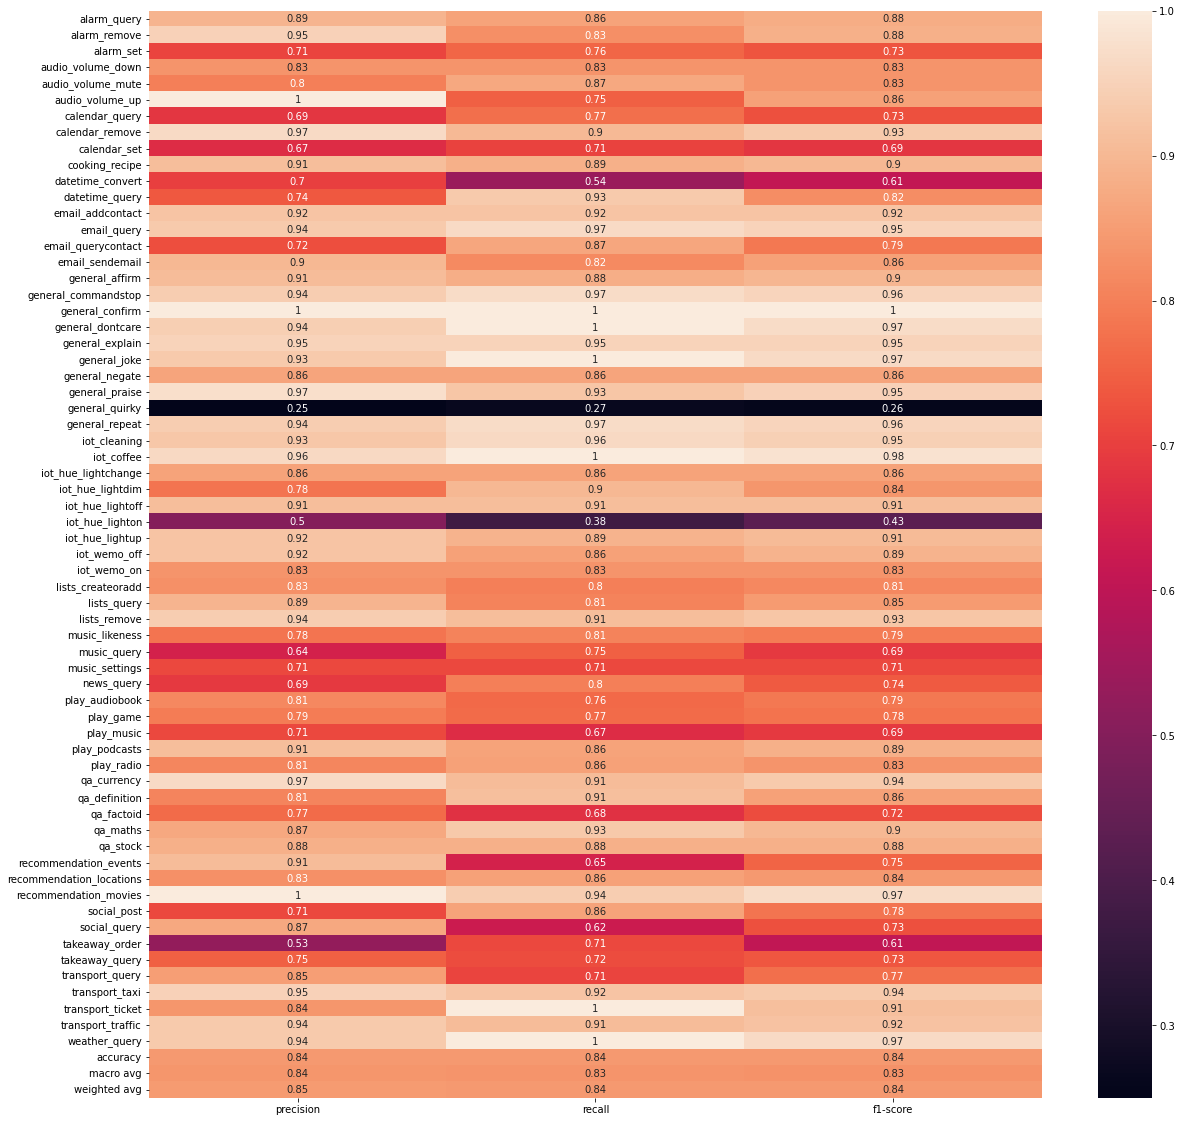

In [23]:
def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(Y_val, pred_val, cat_map)

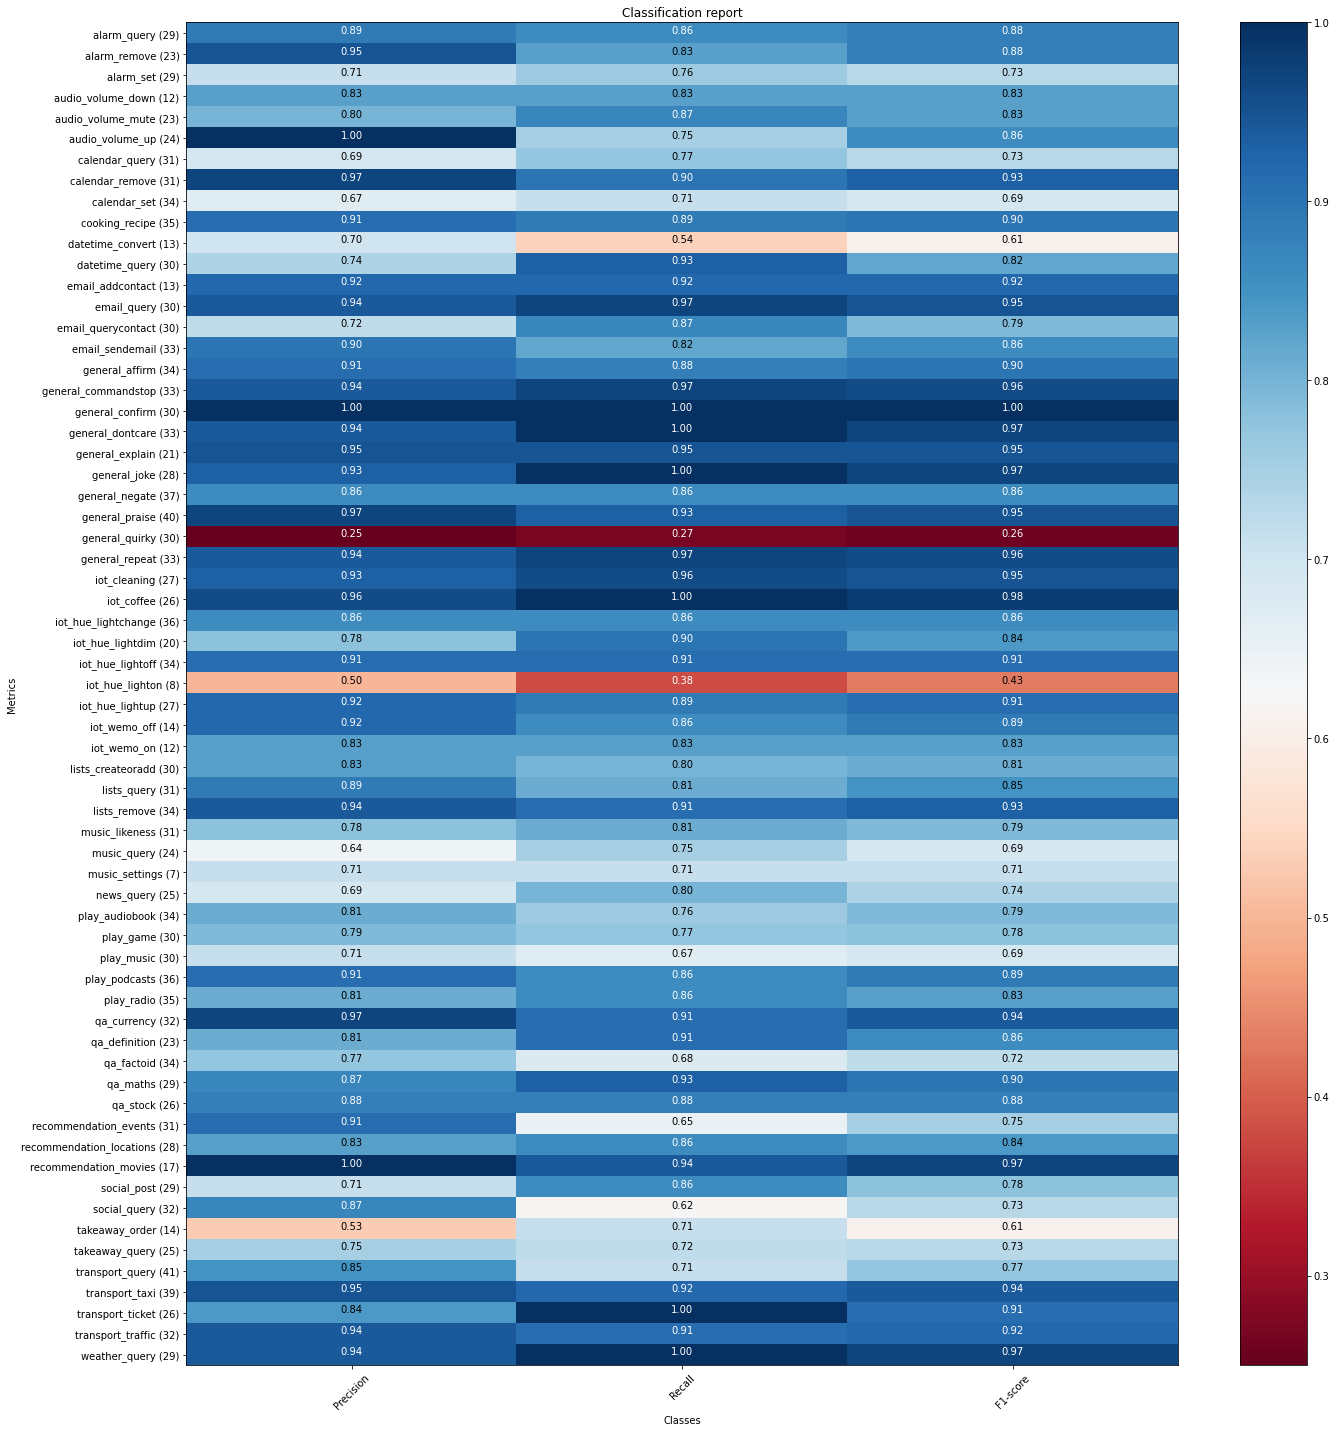

In [26]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(Y_val, pred_val, target_names = list(cat_map.values()))

plot_classification_report(classificationReport)

In [27]:
x_test_embeddings = embedder.encode(X_test, convert_to_numpy=True)
pred_test =model.predict(x_test_embeddings)

In [28]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
my_submission['label'] = my_submission['label'].map(cat_map)
print(my_submission.head())
my_submission.to_csv('Answers_SentTransformer_XGBoost.csv', index=False)

      Id                     label
0  10873                  qa_stock
1   8491  recommendation_locations
2   4549            general_repeat
3   5948               lists_query
4   1663         audio_volume_mute


Build Model Naive Baise

In [29]:
model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB()

In [30]:
pred_val =model.predict(X_val)

In [31]:
print(confusion_matrix(Y_val, pred_val))
print(classification_report(Y_val, pred_val))

[[25  0  4 ...  0  0  0]
 [ 1 21  1 ...  0  0  0]
 [ 2  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 25  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 27]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       1.00      0.91      0.95        23
           2       0.79      0.76      0.77        29
           3       0.69      0.75      0.72        12
           4       0.90      0.78      0.84        23
           5       0.94      0.62      0.75        24
           6       0.65      0.65      0.65        31
           7       0.88      0.90      0.89        31
           8       0.74      0.76      0.75        34
           9       0.91      0.89      0.90        35
          10       0.71      0.92      0.80        13
          11       0.89      0.80      0.84        30
          12       0.92      0.92      0.92        13
          13       0.93      0.90      0.92        30
          14       0.76      0.87

In [32]:
adjusted_rand = adjusted_rand_score(Y_val, pred_val)
adjusted_mutual_info = adjusted_mutual_info_score(Y_val, pred_val)

print("ARI: {}".format(adjusted_rand))
print("AMI: {}".format(adjusted_mutual_info))

ARI: 0.681211685243623
AMI: 0.7936214009172141


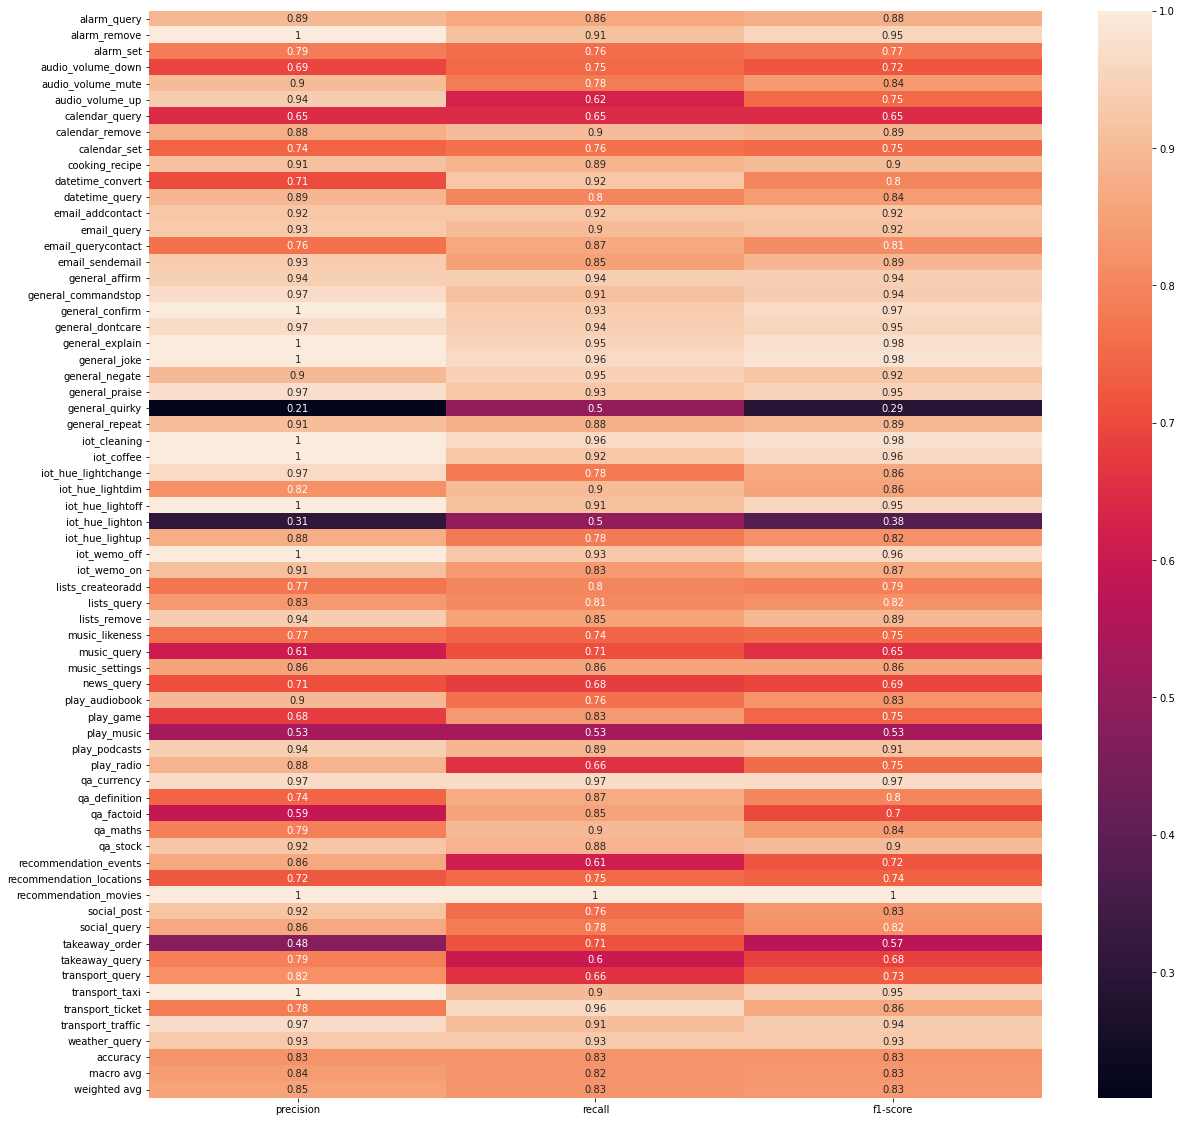

In [33]:
def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(Y_val, pred_val, cat_map)

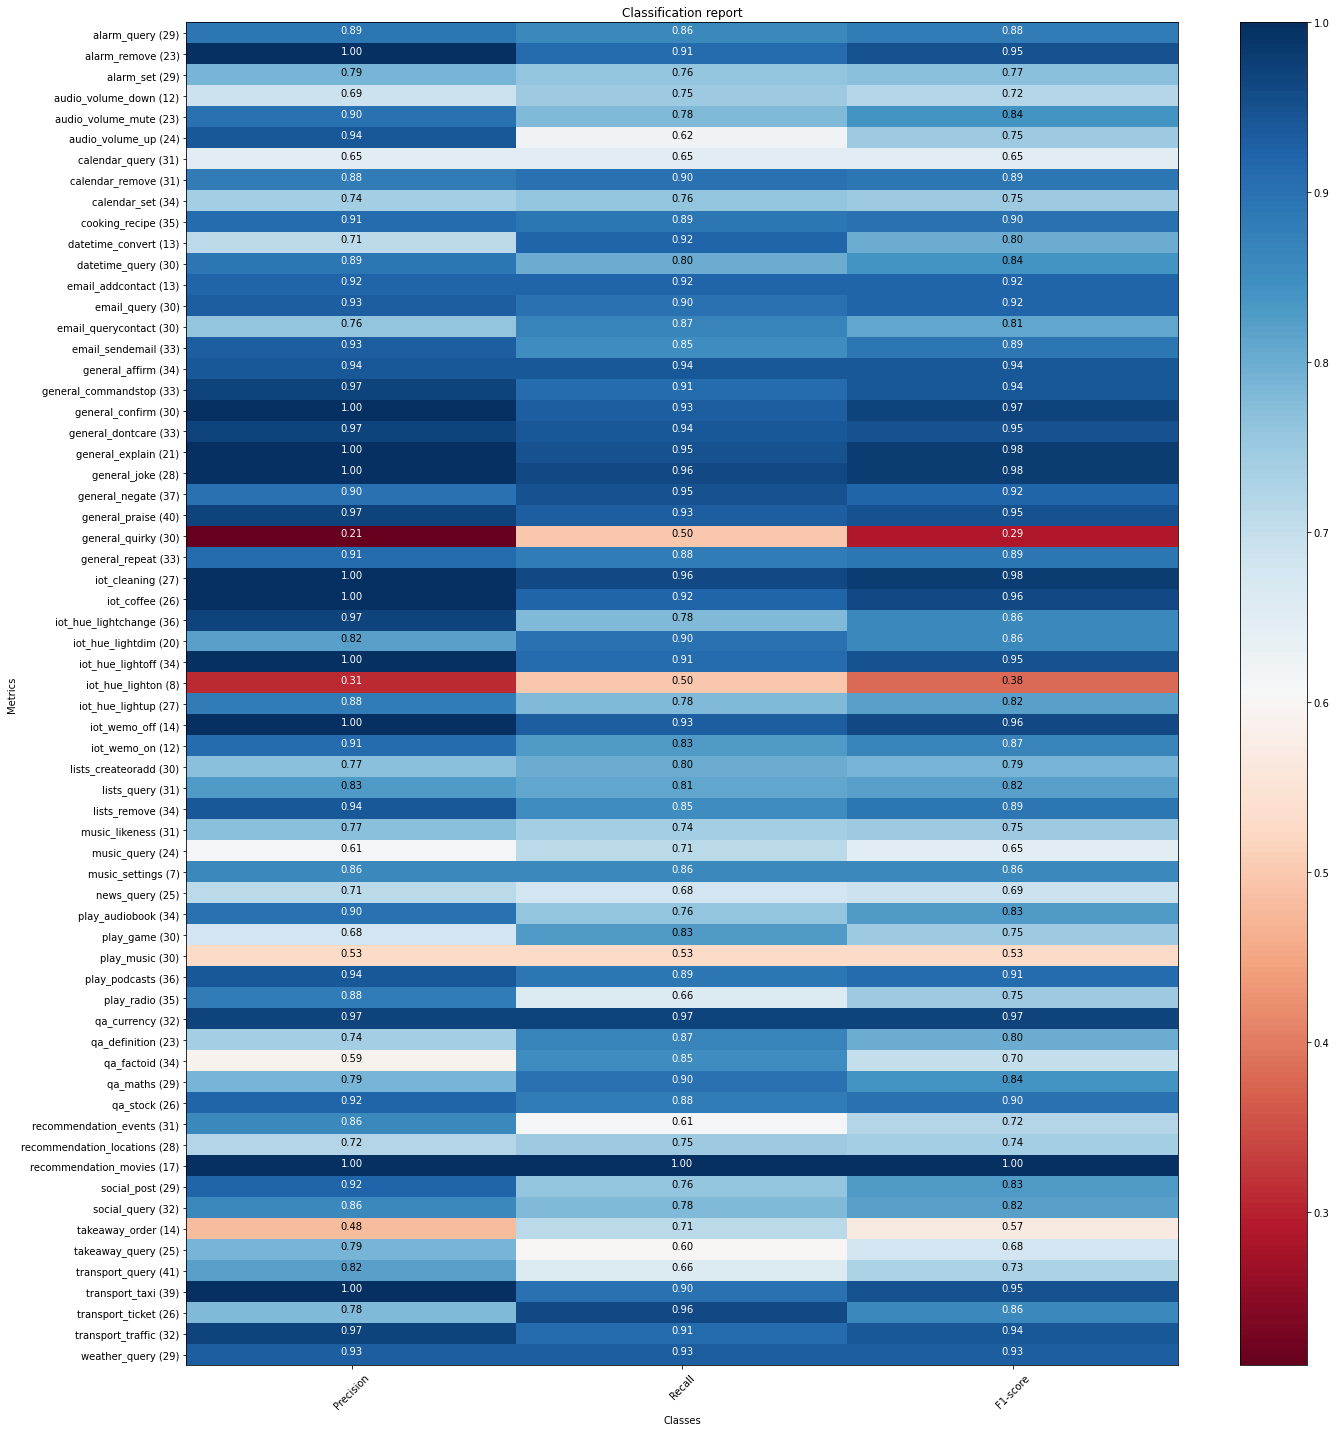

In [34]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(Y_val, pred_val, target_names = list(cat_map.values()))

plot_classification_report(classificationReport)

In [35]:
x_test_embeddings = embedder.encode(X_test, convert_to_numpy=True)
pred_test =model.predict(x_test_embeddings)

In [36]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
my_submission['label'] = my_submission['label'].map(cat_map)
print(my_submission.head())
my_submission.to_csv('Answers_SentTransformer_NB.csv', index=False)

      Id                     label
0  10873                  qa_stock
1   8491  recommendation_locations
2   4549            general_repeat
3   5948               lists_query
4   1663         audio_volume_mute


Build Model Random Forest Classifier

In [37]:
estimator = RandomForestClassifier(n_estimators=300, max_depth=10)
estimator.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=300)

In [38]:
pred_val =model.predict(X_val)

In [39]:
print(confusion_matrix(Y_val, pred_val))
print(classification_report(Y_val, pred_val))

[[25  0  4 ...  0  0  0]
 [ 1 21  1 ...  0  0  0]
 [ 2  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 25  0  0]
 [ 0  0  0 ...  0 29  0]
 [ 0  0  0 ...  0  0 27]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       1.00      0.91      0.95        23
           2       0.79      0.76      0.77        29
           3       0.69      0.75      0.72        12
           4       0.90      0.78      0.84        23
           5       0.94      0.62      0.75        24
           6       0.65      0.65      0.65        31
           7       0.88      0.90      0.89        31
           8       0.74      0.76      0.75        34
           9       0.91      0.89      0.90        35
          10       0.71      0.92      0.80        13
          11       0.89      0.80      0.84        30
          12       0.92      0.92      0.92        13
          13       0.93      0.90      0.92        30
          14       0.76      0.87

In [40]:
adjusted_rand = adjusted_rand_score(Y_val, pred_val)
adjusted_mutual_info = adjusted_mutual_info_score(Y_val, pred_val)

print("ARI: {}".format(adjusted_rand))
print("AMI: {}".format(adjusted_mutual_info))

ARI: 0.681211685243623
AMI: 0.7936214009172141


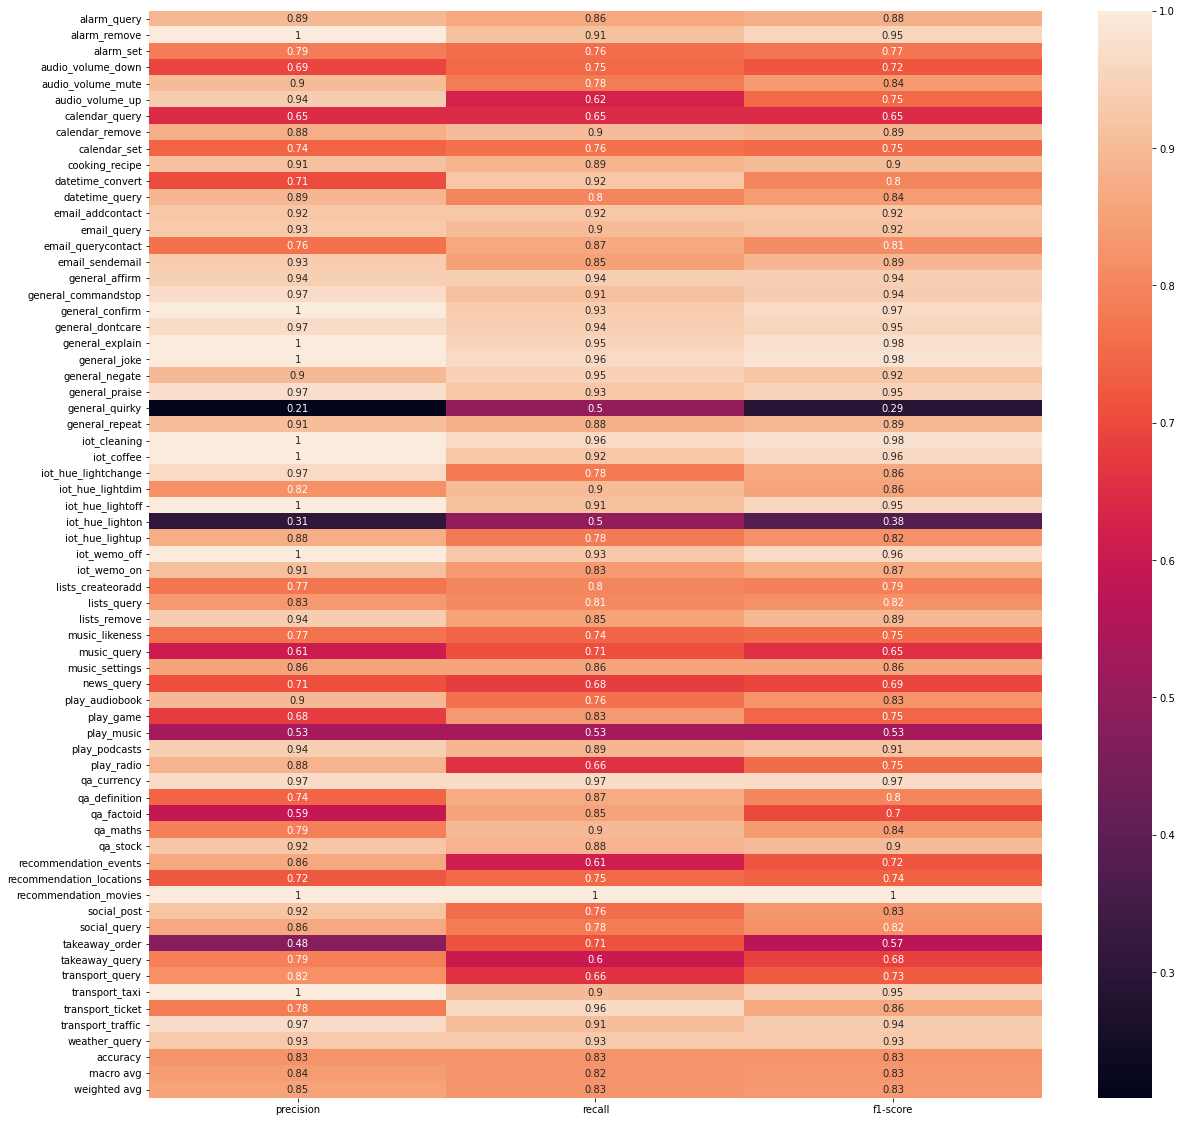

In [41]:
def visualize_classification_report_with_heatmap(test_y, pred_labels, target_names_dict):
  fig, ax = plt.subplots(figsize=(20,20)) 
  clf_report = classification_report(test_y, pred_labels,
                                    target_names=list(target_names_dict.values()),
                                    output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  return

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

visualize_classification_report_with_heatmap(Y_val, pred_val, cat_map)

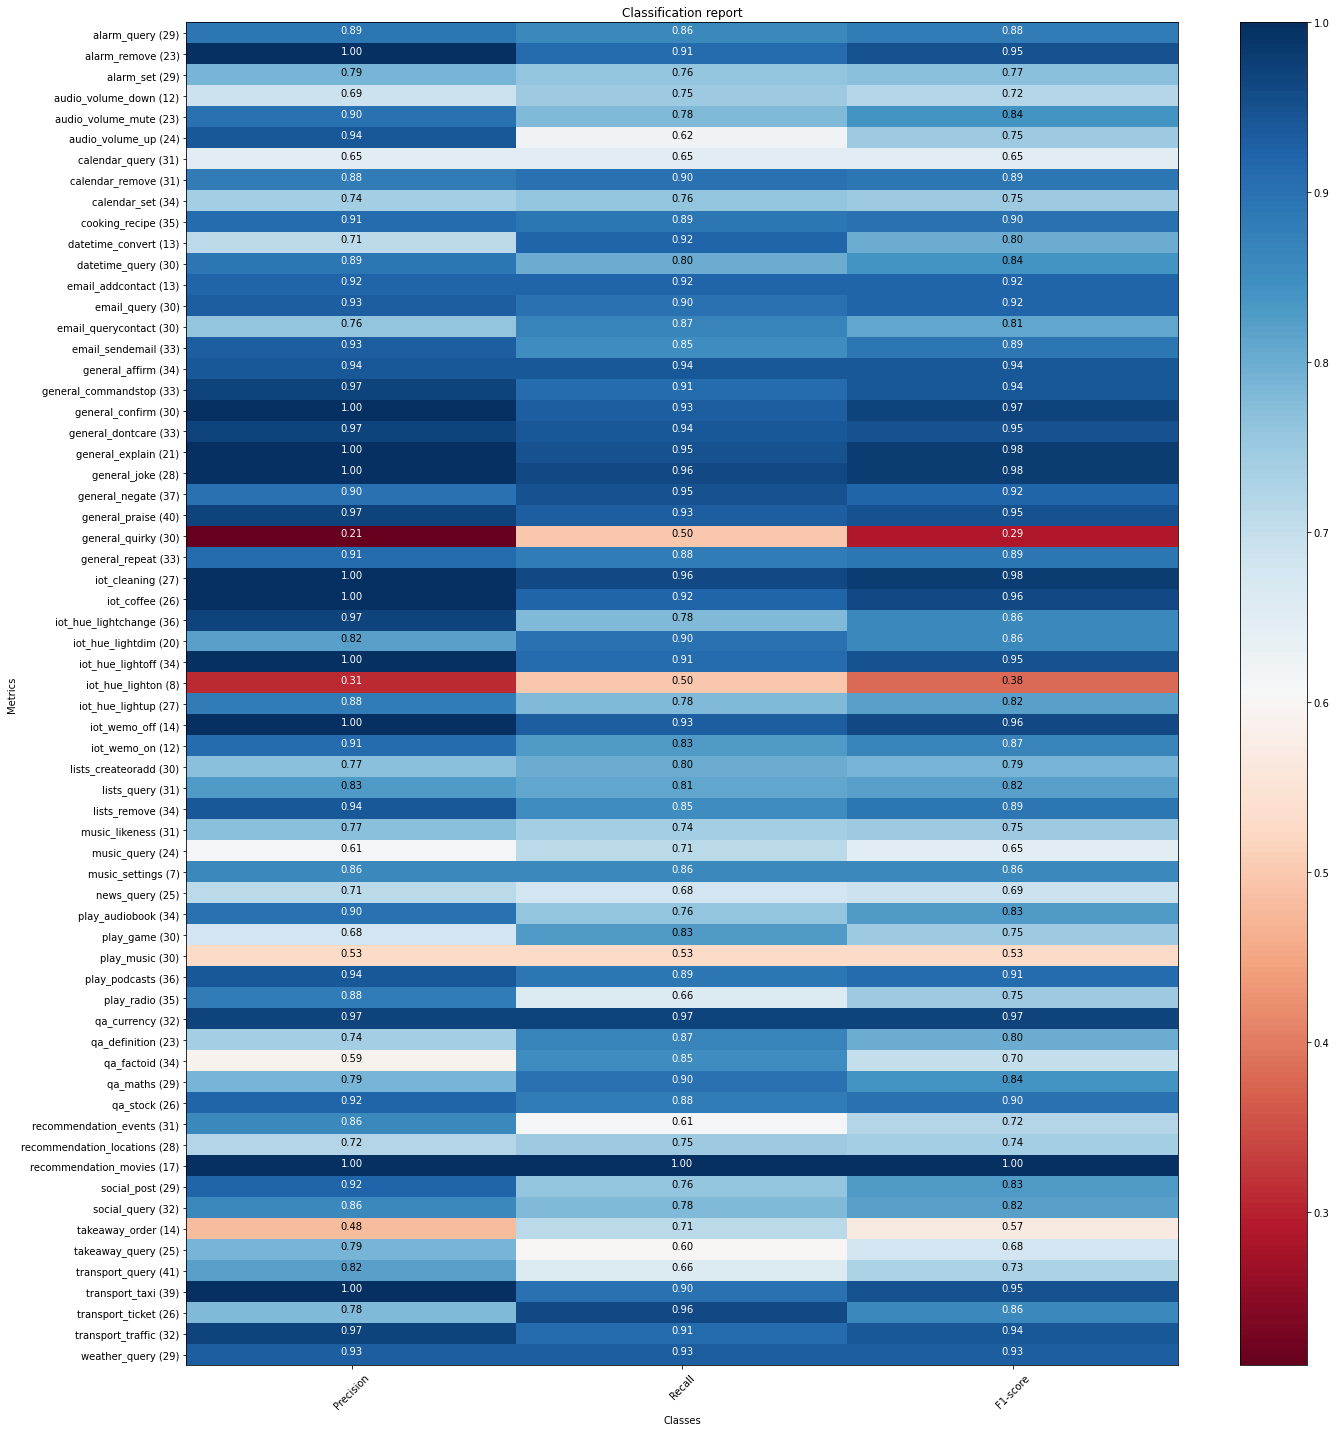

In [42]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace('macro avg', 'macro_avg')
    classificationReport = classificationReport.replace('weighted avg', 'weighted_avg')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want any avg, then change [1:] into [1:-4]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    fig, ax = plt.subplots(figsize=(20,20)) 
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

# Use this dict, if cannot generate from labeled data based dictionary ('label_dict') dynamically
label_dict_fixed={0: 'alarm_query',1: 'alarm_remove',2: 'alarm_set',3: 'audio_volume_down',4: 'audio_volume_mute',5: 'audio_volume_up',6: 'calendar_query',7: 'calendar_remove',8: 'calendar_set',9: 
             'cooking_recipe',10: 'datetime_convert',11: 'datetime_query',12: 'email_addcontact',13: 'email_query',14: 'email_querycontact',15: 'email_sendemail',16: 'general_affirm',17: 'general_commandstop',
             18: 'general_confirm',19: 'general_dontcare',20: 'general_explain',21: 'general_joke',22: 'general_negate',23: 'general_praise',24: 'general_quirky',25: 'general_repeat',26: 'iot_cleaning',
             27: 'iot_coffee',28: 'iot_hue_lightchange',29: 'iot_hue_lightdim',30: 'iot_hue_lightoff',31: 'iot_hue_lighton',32: 'iot_hue_lightup',33: 'iot_wemo_off',34: 'iot_wemo_on',35: 'lists_createoradd',
             36: 'lists_query',37: 'lists_remove',38: 'music_likeness',39: 'music_query',40: 'music_settings',41: 'news_query',42: 'play_audiobook',43: 'play_game',44: 'play_music',45: 'play_podcasts',
             46: 'play_radio',47: 'qa_currency',48: 'qa_definition',49: 'qa_factoid',50: 'qa_maths',51: 'qa_stock',52: 'recommendation_events',53: 'recommendation_locations',54: 'recommendation_movies',
             55: 'social_post',56: 'social_query',57: 'takeaway_order',58: 'takeaway_query',59: 'transport_query',60: 'transport_taxi',61: 'transport_ticket',62: 'transport_traffic',63: 'weather_query'}

classificationReport = classification_report(Y_val, pred_val, target_names = list(cat_map.values()))

plot_classification_report(classificationReport)

In [36]:
x_test_embeddings = embedder.encode(X_test, convert_to_numpy=True)
pred_test =model.predict(x_test_embeddings)

In [37]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
my_submission['label'] = my_submission['label'].map(cat_map)
print(my_submission.head())
my_submission.to_csv('Answers_SentTransformer_RF.csv', index=False)

      Id                     label
0  10873                  qa_stock
1   8491  recommendation_locations
2   4549            general_repeat
3   5948               lists_query
4   1663         audio_volume_mute


Build Model CatBoost

In [38]:
model = CatBoostClassifier(n_estimators=111, max_depth=7, learning_rate=0.01)
model.fit(X_train, Y_train)

0:	learn: 4.1424239	total: 8.88s	remaining: 16m 16s
1:	learn: 4.1248389	total: 17.5s	remaining: 15m 53s
2:	learn: 4.1088540	total: 26.2s	remaining: 15m 43s
3:	learn: 4.0917394	total: 34.9s	remaining: 15m 34s
4:	learn: 4.0775858	total: 43.7s	remaining: 15m 25s
5:	learn: 4.0606292	total: 52.5s	remaining: 15m 18s
6:	learn: 4.0440353	total: 1m 1s	remaining: 15m 9s
7:	learn: 4.0269307	total: 1m 10s	remaining: 15m 2s
8:	learn: 4.0112463	total: 1m 19s	remaining: 14m 59s
9:	learn: 3.9939130	total: 1m 28s	remaining: 14m 49s
10:	learn: 3.9772611	total: 1m 37s	remaining: 14m 41s
11:	learn: 3.9604334	total: 1m 45s	remaining: 14m 32s
12:	learn: 3.9440493	total: 1m 54s	remaining: 14m 22s
13:	learn: 3.9270281	total: 2m 3s	remaining: 14m 13s
14:	learn: 3.9092850	total: 2m 11s	remaining: 14m 3s
15:	learn: 3.8916140	total: 2m 20s	remaining: 13m 55s
16:	learn: 3.8748071	total: 2m 29s	remaining: 13m 45s
17:	learn: 3.8562211	total: 2m 38s	remaining: 13m 36s
18:	learn: 3.8410395	total: 2m 46s	remaining: 13m

In [39]:
pred_val =model.predict(X_val)

In [40]:
print(confusion_matrix(Y_val, pred_val))
print(classification_report(Y_val, pred_val))

[[25  0  4 ...  0  0  0]
 [ 7 13  3 ...  0  0  0]
 [ 3  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 29]]
              precision    recall  f1-score   support

           0       0.69      0.86      0.77        29
           1       1.00      0.57      0.72        23
           2       0.71      0.76      0.73        29
           3       0.86      0.50      0.63        12
           4       0.70      0.70      0.70        23
           5       0.88      0.62      0.73        24
           6       0.57      0.42      0.48        31
           7       0.83      0.94      0.88        31
           8       0.67      0.47      0.55        34
           9       0.89      0.89      0.89        35
          10       1.00      0.08      0.14        13
          11       0.46      0.97      0.62        30
          12       1.00      0.62      0.76        13
          13       0.76      0.93      0.84        30
          14       0.66      0.70

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
pred_val = pred_val.reshape(pred_val, (len(pred_val),0))

TypeError: ignored

In [41]:
adjusted_rand = adjusted_rand_score(Y_val, pred_val)
adjusted_mutual_info = adjusted_mutual_info_score(Y_val, pred_val)

print("ARI: {}".format(adjusted_rand))
print("AMI: {}".format(adjusted_mutual_info))

ValueError: ignored

In [58]:
x_test_embeddings = embedder.encode(X_test, convert_to_numpy=True)
pred_test =model.predict(x_test_embeddings)

In [59]:
my_submission = pd.DataFrame({'Id': df_test['id'], 'label': pred_test})
my_submission['label'] = my_submission['label'].map(cat_map)
print(my_submission.head())
my_submission.to_csv('Answers_SentTransformer_CatBoost.csv', index=False)

ValueError: ignored